## 1. Generate the source dataframes

/home/come.annicchiarico/Envs/my_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


 - Loaded the task results for study 66f96c31e69227986334a027 
    (16 subjects.)
 - Loaded the task results for study 66d086503c0a69291c361b67 
    (40 subjects.)
Total : 56 subjects
55 subjects remaining after removing problematic subjects.
A total of 14/6050 actions were missed. (0.23 %)
 - Loaded the task results for study 6703ab18d345eaa4893587e0 
    (49 subjects.)
 - Loaded the task results for study 66f9aee8210357265a5958fc 
    (50 subjects.)
 - Loaded the task results for study 6703ab1a7ea30557549dc6da 
    (50 subjects.)
Total : 149 subjects
145 subjects remaining after removing problematic subjects.
A total of 33/15950 actions were missed. (0.21 %)
(200, 3)


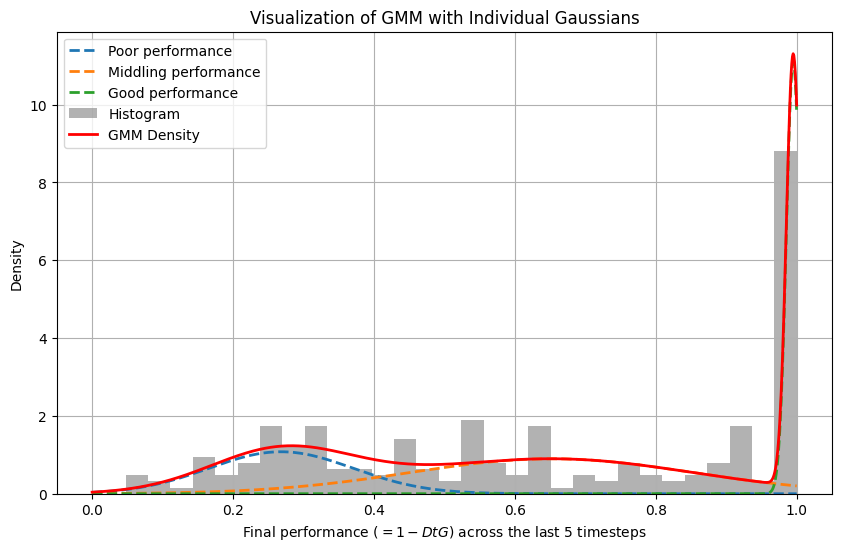

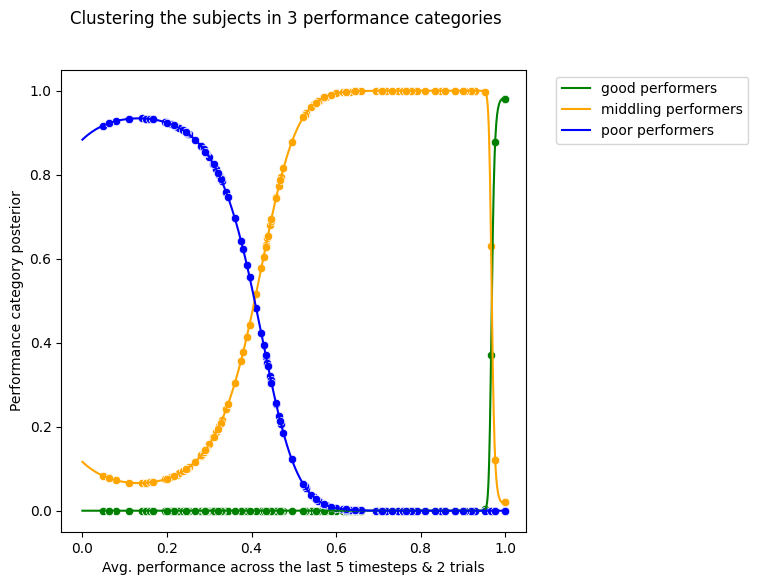

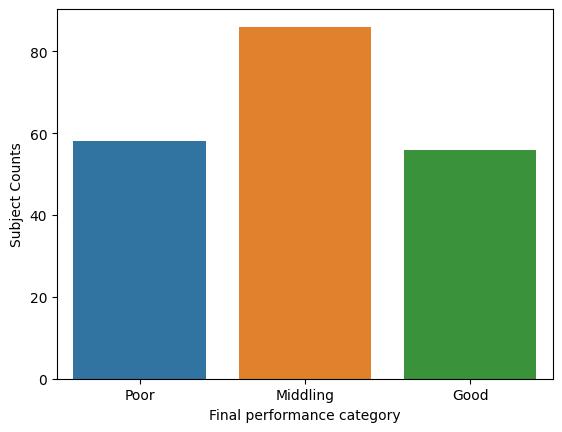

/home/come.annicchiarico/code/behavioural_task/Behavioural_analog_to_BCI_training/results/cluster_inversions/logs


In [ ]:

###### Import packages/modules
import submitit
# memory profiler to evaluate how much your jobs demand
from memory_profiler import memory_usage

import sys,os
import pickle

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import plotly as pltly
import plotly.express as px
import plotly.graph_objects as go

from functools import partial
import importlib   # To import model files with poorly written names  ¯\_(ツ)_/¯
from tabulate import tabulate # to make pretty tables : 

from sklearn.mixture import GaussianMixture

import jax
import jax.numpy as jnp
from jax import vmap
from jax.tree_util import tree_map
import jax.random as jr
import tensorflow_probability.substrates.jax.distributions as tfd
# + local functions : 
from database_handling.database_extract import get_all_subject_data_from_internal_task_id
from utils import remove_by_indices
from analysis_tools.preprocess import get_preprocessed_data_from_df
from analysis_tools.dataframe_from_raw_data import get_full_dataframe_from_raw_data

# The simulated environment :
from simulate.generate_observations_full_actions import TrainingEnvironment,simulate_training
from simulate.hmm_weights import behavioural_process # The environment is statically defined by its HMM matrices
from simulate.generate_observations_full_actions import generate_synthetic_data

# The inversion scripts :
from simulate.compute_likelihood_full_actions import compute_predicted_actions,compute_loglikelihood
from simulate.compute_likelihood_full_actions import fit_mle_agent,fit_map_agent
from simulate.invert_model import invert_data_for_single_model,invert_data_for_library_of_models,invert_data_for_single_model_cluster
from simulate.simulate_utils import ind2sub,discretize_normal_pdf

from simulate.plot_trajectory import plot_actions,plot_learnt_transition_matrix,plot_learnt_q_table

# The agent class : 
from simulate.general_agent import Agent

LLM_CLASSIFS_PATH = os.path.join("results","llm_classifications","29_01.data")

STUDIES_EXTRACTION_CODES = {
    # "study_1" : {
    #     "dict_code" : "002",
    #     "internal_task_id" : "002",
    #     "studies_id" : None,
    #     "exclude_subjects" : ["5c9cb670b472d0001295f377"],
    #     "feedback_noise_bins" : [0,0.2,0.4,1]
    # },
    "study_2" : {
        "dict_code" : "003_1",
        "internal_task_id" : "003",
        "studies_id" :  ["66f96c31e69227986334a027","66d086503c0a69291c361b67"],
        "exclude_subjects" : ["615c1741d4630b25e6bc1cb9"],
        "feedback_noise_bins" : [0,0.05,0.15,1]
    },
    "study_3" : {
        "dict_code" : "003_2",
        "internal_task_id" : "003",
        "studies_id" : ["6703ab18d345eaa4893587e0","66f9aee8210357265a5958fc","6703ab1a7ea30557549dc6da"],
        "exclude_subjects" : ["611d60c383f4f70ff4bc99fd", "66a74bdfdcaccdc0703894d5",
                              "667d92f2ea5c1542f417285d", "6548f570022275786186ffbd"],
        "feedback_noise_bins" : [0,0.05,0.15,1]
    }
}

LAST_T_TIMESTEPS = 5
LAST_K_TRIALS = 2
subjects_df = get_full_dataframe_from_raw_data(STUDIES_EXTRACTION_CODES,LLM_CLASSIFS_PATH,LAST_T_TIMESTEPS,LAST_K_TRIALS)


EXECUTOR_LOGPATH = os.path.join("results","cluster_inversions","logs")
RESULTS_SAVEPATH = os.path.join("results","cluster_inversions","inversion_mle_no_selector")
if not os.path.exists(RESULTS_SAVEPATH):
    os.makedirs(RESULTS_SAVEPATH)
print(os.path.join(os.getcwd(),EXECUTOR_LOGPATH))


n_jours_max = 7
JOB_MAXTIME = 60*24*n_jours_max
JOB_CPUS = 8
JOB_PARTITION = 'CPU'
JOB_NODES = 1
JOB_MAX_ARRAY = 30
JOB_NAME_FUNC = (lambda x : "BRUH_{}".format(x))
method = 'mle'

## 2. Preprocess the data 

In [2]:
inverted_dataframe = subjects_df[(subjects_df["study_name"]=="study_2")|(subjects_df["study_name"]=="study_3")]
# environment constants :
NTRIALS = 10
T = 11

# MODEL CONSTANTS :
N_LATENT_STATES = 5

# ENVIRONMENTAL CONSTANTS :
N_FEEDBACK_OUTCOMES = 10
TRUE_FEEDBACK_STD =   0.175#0.025#0.175#0.025
GRID_SIZE = (7,7)
START_COORD = [[5,1],[5,2],[4,1]]
END_COORD = [0,6]

# The weights of the HMM environment
(a,b,c,d,e,u),fb_vals = behavioural_process(GRID_SIZE,START_COORD,END_COORD,N_FEEDBACK_OUTCOMES,TRUE_FEEDBACK_STD)

rngkey = jax.random.PRNGKey(np.random.randint(0,10))
ENVIRONMENT = TrainingEnvironment(a,b,c,d,e,u,T,NTRIALS)



# define the static dimensions of the problem :
No = N_FEEDBACK_OUTCOMES
Ns = N_LATENT_STATES
MODEL_CONSTANTS = {
    "position" : {
        "Th" : 2,
        "N_actions" : 9,
        "N_outcomes" : No,
        "N_states" : Ns
    },
    "angle" : {
        "Th" : 2,
        "N_actions" : 9,
        "N_outcomes" : No,
        "N_states" : Ns
    },
    "distance" : {
        "Th" : 2,
        "N_actions" : 4,
        "N_outcomes" : No,
        "N_states" : Ns
    },
}


# If the points were too close, no angle was recorded :
# The limit was arbitrarily chosen at 7.5 units :
min_dist_norm = 7.5/(np.sqrt(2)*750)

preprocessing_options = {
    "actions":{
        "distance_bins" : np.array([0.0,min_dist_norm,0.2,0.5,jnp.sqrt(2) + 1e-10]),
        "angle_N_bins"  : 8,
        "position_N_bins_per_dim" : 3
    },
    "observations":{
        "N_bins" : N_FEEDBACK_OUTCOMES,
        "observation_ends_at_point" : 2
    }
}
# We can modify these at will


# The preprocessing here assumes two possible observations : 
# - the mean of the gauge level between subject actions (index 0) 
# - the last value before subject action (index 1).
inverted_data_all = get_preprocessed_data_from_df(inverted_dataframe,
                            preprocessing_options,
                            verbose=True,
                            autosave=True,autoload=True,override_save=True,
                            label="default",
                            filter_angles_if_small_distance = True)


formatted_stimuli= [inverted_data_all["observations"]["vect"][1]]
bool_stimuli = [jnp.ones_like(stim[...,0]) for stim in formatted_stimuli] # Everything was seen :)
rewards = jnp.array(inverted_data_all["observations"]["deltas"])

actions = {}
for action_dim in ["position","distance","angle"]:
    actions[action_dim] = jnp.array(inverted_data_all["actions"]["vect"][action_dim])[:,:-1,:,:] # Ignore the last trial

Nsubj,Ntrials,Nactions,_ = actions[action_dim].shape
timesteps = jnp.broadcast_to(jnp.arange(Nactions+1),(Nsubj,Ntrials,Nactions+1))

inverted_data = (formatted_stimuli,bool_stimuli,rewards,actions,timesteps)



formatted_stimuli,_,_,_,_ = inverted_data
Nsubj,Ntrials,Ntimesteps,_ = formatted_stimuli[0].shape

Out of the 22000.0 actions performed by our subjects, 21953.0 were 'valid' (99.8 %)
Out of the 22000.0 feedback sequences potentially observed by our subjects, 22000 were 'valid' (100.0 %)


## 3. Model space

Here, we define all the models we want to check against our subject datas !

In [ ]:

invert_these = []

# RW models with no modality selection : 
for free_parameters in ["independent","mixed"]:
    for assymetric_learning_rate in [True,False] :
        for biases in [[],["static"],["initial"],["static","initial"]]:
            invert_these.append({
                "model_family" : "rw",  # "rw" / "latql" / "tracking_rw"
                "free_parameters" : free_parameters,
                "biaises" : biases,
                "assymetric_learning_rate" : assymetric_learning_rate,
                "modality_selector" : None,
                "generalizer" : False,
                "memory" : "5000M",
            })
                    
# latql models without modality selection :
for free_parameters in ["independent","mixed"]:
    for assymetric_learning_rate in [True,False] :
        for biases in [[],["static"],["initial"],["static","initial"]]:
            for focused_learning in [True,False]:
                for independent_focused_learning in [True,False]:
                    invert_these.append({
                        "model_family" : "latql",  # "rw" / "latql" / "tracking_rw"
                        "free_parameters" : free_parameters,
                        "biaises" : biases,
                        "assymetric_learning_rate" : assymetric_learning_rate,
                        "modality_selector" : None,
                        "generalizer" : {
                            "transitions_generalize" : True,
                            "qtable_generalize" : True
                        },
                        "memory" : "120000M",
                    })


# aif models without modality selection :
for free_parameters in ["independent","mixed"]:
    for biases in [[],["initial"]]:
        for learn_habits in [True,False]:
            for set_initial_b_confidence in [True,False]:
                invert_these.append({
                    "model_family" : "aif",  # "rw" / "latql" / "tracking_rw"
                    "free_parameters" : free_parameters,
                    "biaises" : biases,
                    "learn_habits" : learn_habits,
                    "learn_during_trials" :True,
                    "modality_selector" : None,
                    "generalizer" : {
                                "transitions_generalize" : True,
                    },
                    "set_initial_transition_confidence" : set_initial_b_confidence,
                    "efe_compute_method" : "classic",
                    "vectorize_fit" : False,
                    "one_job_per_subj_option":True,
                    "memory" : "20000M",
                })


memories = [m["memory"] for m in invert_these]
agents = [Agent(m,MODEL_CONSTANTS) for m in invert_these]
MODEL_LIBRARY = {a.get_name() : {"agent" :a,"tags" : a.get_tags(),"memory":m} for (a,m) in zip(agents,memories)}
print(MODEL_LIBRARY.keys())


print("Inverting a total of {} models.".format(len(MODEL_LIBRARY)))

dict_keys(['i_rwa', 'i_rwa+b', 'i_rwa&b', 'i_rwa+b&b', 'i_rw', 'i_rw+b', 'i_rw&b', 'i_rw+b&b', 'm_rwa', 'm_rwa+b', 'm_rwa&b', 'm_rwa+b&b', 'm_rw', 'm_rw+b', 'm_rw&b', 'm_rw+b&b', 'i_latqla-bgen-qgen', 'i_latqla+b-bgen-qgen', 'i_latqla&b-bgen-qgen', 'i_latqla+b&b-bgen-qgen', 'i_latql-bgen-qgen', 'i_latql+b-bgen-qgen', 'i_latql&b-bgen-qgen', 'i_latql+b&b-bgen-qgen', 'm_latqla-bgen-qgen', 'm_latqla+b-bgen-qgen', 'm_latqla&b-bgen-qgen', 'm_latqla+b&b-bgen-qgen', 'm_latql-bgen-qgen', 'm_latql+b-bgen-qgen', 'm_latql&b-bgen-qgen', 'm_latql+b&b-bgen-qgen', 'i_aifclassicLlebc-bgen', 'i_aifclassicLle-bgen', 'i_aifclassicLbc-bgen', 'i_aifclassicL-bgen', 'i_aifclassicLlebc&b-bgen', 'i_aifclassicLle&b-bgen', 'i_aifclassicLbc&b-bgen', 'i_aifclassicL&b-bgen', 'm_aifclassicLlebc-bgen', 'm_aifclassicLle-bgen', 'm_aifclassicLbc-bgen', 'm_aifclassicL-bgen', 'm_aifclassicLlebc&b-bgen', 'm_aifclassicLle&b-bgen', 'm_aifclassicLbc&b-bgen', 'm_aifclassicL&b-bgen'])
Inverting a total of 48 models.


In [4]:
# Check for duplicates :
namelist = list(MODEL_LIBRARY.keys())
print(len(namelist) == len(set(namelist)))


# Get a typical hyperparameter dictionnary for each model :
parameter_count_list = []
for model_name,model_contents in MODEL_LIBRARY.items():   
    parameter_set_tree = model_contents["agent"].get_random_parameters(jr.PRNGKey(0))

    vls,_ = (jax.tree.flatten(tree_map(lambda x : x.shape[0],parameter_set_tree)))    
    
    nbr,_ = (jax.tree.flatten(tree_map(lambda x : 1,parameter_set_tree)))    

    parameter_count_list.append([model_name,sum(vls),sum(nbr)])#"{}({:.1f} %)".format(sum(nbr),(sum(nbr)+1e-10)/(sum(vls)+1e-10)*100)])

print(tabulate(parameter_count_list, headers=['model name', '# of parameters \n(scalar values)','# of parameters \n(distinct variables)'], tablefmt='orgtbl'))   
 

True
| model name               |   # of parameters  |       # of parameters  |
|                          |    (scalar values) |   (distinct variables) |
|--------------------------+--------------------+------------------------|
| i_rwa                    |                  9 |                      9 |
| i_rwa+b                  |                 34 |                     15 |
| i_rwa&b                  |                 31 |                     12 |
| i_rwa+b&b                |                 56 |                     18 |
| i_rw                     |                  6 |                      6 |
| i_rw+b                   |                 31 |                     12 |
| i_rw&b                   |                 28 |                      9 |
| i_rw+b&b                 |                 53 |                     15 |
| m_rwa                    |                  3 |                      3 |
| m_rwa+b                  |                 26 |                      7 |
| m_rwa&b           

We want to parrallelize the inversion of each of those models on the cluster ! 
The bigger ones have a significant computational overhead making them unfit for parrallelization. Thus, we perform the inversion subject per subject. The smaller ones (rw models) can be inverted in parallel :

In [ ]:
# for model_name,model_contents in MODEL_LIBRARY.items():

#     #if "latql" in model_contents["tags"]:
#     #   model_contents["vectorize_fit"] = False 

#     # In the absence of parrallelized computation, the AIF models are quite expensive to invert :
#     if "aif" in model_contents["tags"]:
#         model_contents["vectorize_fit"] = False 
#         model_contents["one_job_per_subj_option"] = True
    

In [ ]:
init_lr = 1e-1
n_steps = 15
n_heads = 2
lr_scheduler = {250:init_lr/2,650:init_lr/10}

rngkey = jr.PRNGKey(0)
option_verbose = True

model_library =MODEL_LIBRARY# {'random' : MODEL_LIBRARY["random"]}
print(model_library)



# To test the inversions outside of the cluster : 

# RESULTS_SAVEPATH = os.path.join("results","inversions","cluster_test")
    
# RESULTS = invert_data_for_library_of_models(inverted_data,model_library,method=method,
#                                   standard_n_heads=n_heads,standard_n_steps=n_steps,lr=init_lr,lr_scheduler=lr_scheduler,
#                                    rngkey=rngkey,
#                                    save=True,save_directory=RESULTS_SAVEPATH,override=False)



# loop over array_parallel
print('#### Start submitting jobs #####')

# initialize a list in which our returning jobs will be stored
joblist=[]
for i,(agent_name, agent_contents) in enumerate(model_library.items()):
    print("     -> Agent : {}".format(agent_name))
    local_savepath = os.path.join(RESULTS_SAVEPATH,agent_name)
    rngkey,local_key = jr.split(rngkey)

    # executor is the submission interface (logs are dumped in the folder)
    # note that the executor was modified since the first version of this tutorial (it used to be AutoExecutor).
    # This has implications for the key-value pairs that can be passed to update_parameters.
    executor = submitit.SlurmExecutor(folder=os.path.join(os.getcwd(),EXECUTOR_LOGPATH), max_num_timeout=5)
    # define execution parameters (see below for a list of common options)
    executor.update_parameters(mem=agent_contents["memory"],cpus_per_task=JOB_CPUS, time=JOB_MAXTIME, 
                               partition =JOB_PARTITION,nodes=JOB_NODES, job_name=JOB_NAME_FUNC(agent_name),
                               array_parallelism =JOB_MAX_ARRAY)

    
    one_job_per_subj_option = (agent_contents["one_job_per_subj_option"] if ("one_job_per_subj_option" in agent_contents) else False)
    if one_job_per_subj_option:
        joblist = invert_data_for_single_model_cluster(executor,joblist, 
                        inverted_data, agent_contents,
                        method=method,
                        standard_n_heads = n_heads,standard_n_steps = n_steps,lr=init_lr,lr_scheduler=lr_scheduler,
                        rngkey = local_key,option_verbose = option_verbose,
                        save=True,save_directory=local_savepath,override=False)
    else :
        job_function = partial(invert_data_for_single_model,method=method,
                            standard_n_heads = n_heads,standard_n_steps = n_steps,lr=init_lr,lr_scheduler=lr_scheduler,
                            rngkey = local_key,option_verbose = option_verbose,
                            save=True,save_directory=local_savepath,override=False)
         
        # actually submit the job: note that "agent_contents" correspond to that of the inverted model in this iteration
        job = executor.submit(job_function, inverted_data, agent_contents)
        
        # add info about job submission order
        job.job_initial_indice=i 
            
        # print the ID of your job
        print("     >>> submit job" + str(job.job_id))  
        
        # append the job to the joblist
        joblist.append(job)

### wait for jobs to return (in the correct submission order)
print('#### Start waiting for jobs to return #####')
finished_results = [job.result() for job in joblist]

### display jobs
print('#### All jobs completed #####')
print(len(finished_results))
    

{'i_rwa': {'agent': <simulate.general_agent.Agent object at 0x7f437a9658d0>, 'tags': ['independent', 'rw', 'assymetric'], 'memory': '5000M'}, 'i_rwa+b': {'agent': <simulate.general_agent.Agent object at 0x7f437aacb250>, 'tags': ['independent', 'rw', 'assymetric', 'static_bias'], 'memory': '5000M'}, 'i_rwa&b': {'agent': <simulate.general_agent.Agent object at 0x7f437a94f550>, 'tags': ['independent', 'rw', 'assymetric', 'initial_bias'], 'memory': '5000M'}, 'i_rwa+b&b': {'agent': <simulate.general_agent.Agent object at 0x7f437ae4e390>, 'tags': ['independent', 'rw', 'assymetric', 'static_bias', 'initial_bias'], 'memory': '5000M'}, 'i_rw': {'agent': <simulate.general_agent.Agent object at 0x7f4404165410>, 'tags': ['independent', 'rw'], 'memory': '5000M'}, 'i_rw+b': {'agent': <simulate.general_agent.Agent object at 0x7f437a967110>, 'tags': ['independent', 'rw', 'static_bias'], 'memory': '5000M'}, 'i_rw&b': {'agent': <simulate.general_agent.Agent object at 0x7f437a824c50>, 'tags': ['independe